[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\35088\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\35088\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


开始处理图表(a)：Bounding box 数据
已处理文件: PD16-MW-00100000_caption_en.txt
已处理文件: PD16-MW-00100001_caption_en.txt
已处理文件: PD16-MW-00100002_caption_en.txt
已处理文件: PD16-MW-00100003_caption_en.txt
已处理文件: PD16-MW-00100004_caption_en.txt
已处理文件: PD16-MW-00100005_caption_en.txt
已处理文件: PD16-MW-00100006_caption_en.txt
已处理文件: PD16-MW-00100007_caption_en.txt
已处理文件: PD16-MW-00100008_caption_en.txt
已处理文件: PD16-MW-00100009_caption_en.txt
已处理文件: PD16-MW-00100010_caption_en.txt
已处理文件: PD16-MW-00100012_caption_en.txt
已处理文件: PD16-MW-00100013_caption_en.txt
已处理文件: PD16-MW-00100014_caption_en.txt
已处理文件: PD16-MW-00100015_caption_en.txt
已处理文件: PD16-MW-00100016_caption_en.txt
已处理文件: PD16-MW-00100017_caption_en.txt
已处理文件: PD16-MW-00100018_caption_en.txt
已处理文件: PD16-MW-00100019_caption_en.txt
已处理文件: PD16-MW-00100020_caption_en.txt
已处理文件: PD16-MW-00100022_caption_en.txt
已处理文件: PD16-MW-00100023_caption_en.txt
已处理文件: PD16-MW-00100024_caption_en.txt
已处理文件: PD16-MW-00100025_caption_en.txt
已处理文件: PD16-MW-00100026_caption_en.txt

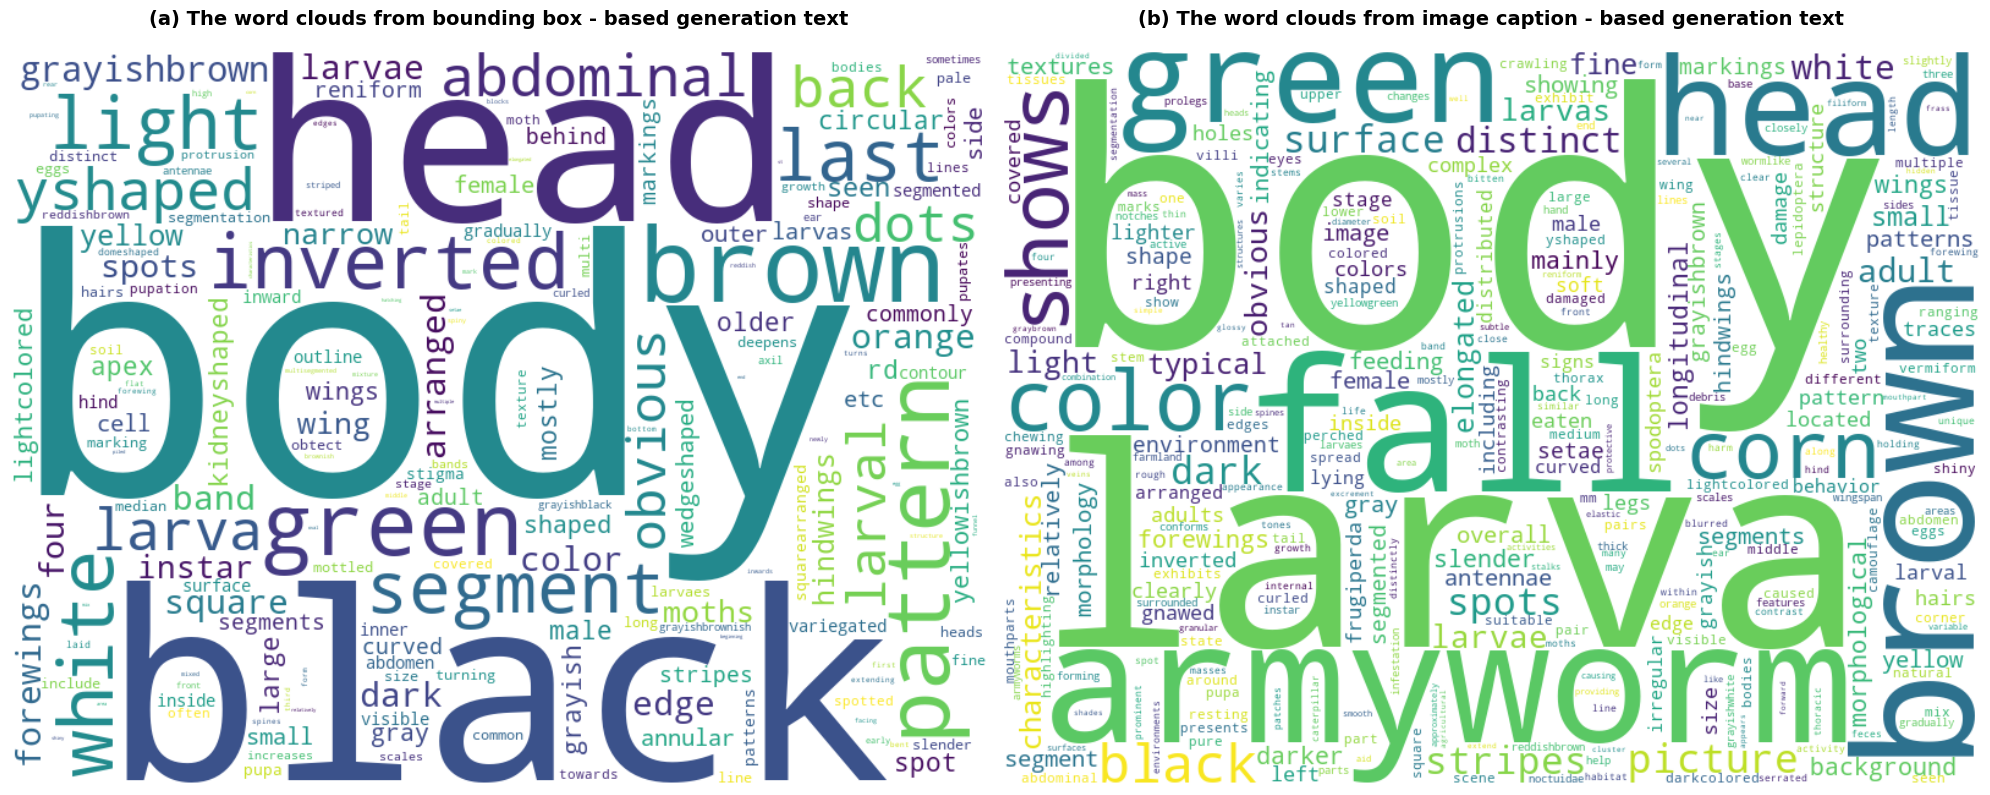

In [ ]:
import os
import json
import re
import string
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# ----------------------
# 1. 全局样式配置（保持原风格）
# ----------------------
plt.style.use('seaborn-v0_8-muted')  # 低饱和度风格
plt.rcParams["font.family"] = ["Times New Roman", "Arial"]  # 英文显示
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 8
plt.rcParams['figure.titlesize'] = 14

# 自定义颜色（原RGB转0-1范围）
custom_colors_rgb = [
    (144, 201, 231),
    (33, 158, 188),
    (19, 103, 131),
    (2, 48, 74),
    (254, 183, 5),
    (255, 158, 2),
    (250, 134, 0),
    (120, 80, 200)  
]
custom_colors = [(r/255, g/255, b/255) for r, g, b in custom_colors_rgb]

# 下载NLTK资源（首次运行需下载）
nltk.download('punkt_tab')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))  # 英文停用词表
# 扩展停用词表
additional_stopwords = {'pest', 'pests', 'insect', 'insects', 'plant', 'plants', 'leaf', 'leaves', 'crop', 'crops'}
stop_words.update(additional_stopwords)


# ----------------------
# 2. 数据加载与预处理（逻辑不变）
# ----------------------
def extract_text(folder_path, target_field):
    """
    提取指定文件夹中文件的目标文本字段
    :param folder_path: 文件夹路径
    :param target_field: 目标字段名称
    :return: 提取到的文本列表
    """
    text_list = []
    
    # 根据目标字段确定要处理的文件类型
    file_patterns = []
    if target_field == "The Characteristics of pest EN":
        file_patterns = ['.txt', '.json']  # bounding box数据文件
    elif target_field == "The image caption EN":
        file_patterns = ['caption.txt']  # image caption数据文件
    
    # 遍历文件夹下的所有文件
    for filename in os.listdir(folder_path):
        # 检查文件是否符合目标模式
        if any(filename.endswith(pattern) for pattern in file_patterns):
            file_path = os.path.join(folder_path, filename)
            try:
                with open(file_path, 'r', encoding='utf-8') as f:
                    content = f.read()
                    # 处理可能的JSON格式问题
                    content = re.sub(r',\s*}', '}', content)
                    data = json.loads(content)
                    
                    # 提取文本内容（根据不同字段采用不同提取方式）
                    if target_field == "The Characteristics of pest EN":
                        # 处理多pest条目
                        pest_num = 1
                        while True:
                            pest_key = f'pest {pest_num}'
                            if pest_key not in data:
                                break
                            text = data[pest_key].get(target_field, '').strip()
                            if text:
                                text_list.append(text)
                            pest_num += 1
                    else:
                        # 处理单一条目
                        text = data.get(target_field, '').strip()
                        if text:
                            text_list.append(text)
                
                print(f"已处理文件: {filename}")
            except Exception as e:
                print(f"处理文件 {filename} 时出错: {str(e)}")
    
    return text_list


def preprocess_text(text):
    """预处理文本：小写化、去除标点和特殊字符"""
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text


def get_word_frequencies(texts):
    """获取词频统计"""
    combined_text = ' '.join(texts)
    processed_text = preprocess_text(combined_text)
    tokens = word_tokenize(processed_text)
    filtered_tokens = [token for token in tokens if token not in stop_words and len(token) > 1]
    return Counter(filtered_tokens)


# ----------------------
# 3. 核心：左右分布（1行2列）合并词云图表
# ----------------------
def plot_combined_wordclouds(bbox_folder, caption_folder, output_path='combined_wordclouds.png'):
    """
    左右分布绘制两张词云图表：
    左图(a)：The word clouds from bounding box - based generation text
    右图(b)：The word clouds from image caption - based generation text
    """
    # 1. 提取并处理两种文本数据
    print("提取Bounding box数据...")
    bbox_texts = extract_text(bbox_folder, "The Characteristics of pest EN")
    if not bbox_texts:
        print("错误：未提取到Bounding box文本数据")
        return
    
    print("\n提取Image caption数据...")
    caption_texts = extract_text(caption_folder, "The image caption EN")
    if not caption_texts:
        print("错误：未提取到Image caption文本数据")
        return
    
    # 2. 计算词频
    bbox_word_freq = get_word_frequencies(bbox_texts)
    caption_word_freq = get_word_frequencies(caption_texts)
    
    # 3. 创建1行2列的子图容器
    fig, (ax_left, ax_right) = plt.subplots(
        nrows=1, ncols=2,  # 1行2列
        figsize=(16, 8),   # 宽16、高8，适配词云显示
        sharey=False       # 不共享y轴
    )

    # ----------------------
    # 左图(a)：Bounding box词云
    # ----------------------
    # 生成词云
    bbox_wordcloud = WordCloud(
        width=800,
        height=600,
        background_color='white',
        max_words=300,
        contour_width=1,
        contour_color='green'
    ).generate_from_frequencies(bbox_word_freq)
    
    # 显示词云
    ax_left.imshow(bbox_wordcloud, interpolation='bilinear')
    ax_left.axis('off')  # 隐藏坐标轴
    ax_left.set_title(
        '(a) The word clouds from bounding box - based generation text',
        pad=20
    )

    # ----------------------
    # 右图(b)：Image caption词云
    # ----------------------
    # 生成词云
    caption_wordcloud = WordCloud(
        width=800,
        height=600,
        background_color='white',
        max_words=300,
        contour_width=1,
        contour_color='green'
    ).generate_from_frequencies(caption_word_freq)
    
    # 显示词云
    ax_right.imshow(caption_wordcloud, interpolation='bilinear')
    ax_right.axis('off')  # 隐藏坐标轴
    ax_right.set_title(
        '(b) The word clouds from image caption - based generation text',
        pad=20
    )

    # ----------------------
    # 4. 优化布局，保存图表
    # ----------------------
    plt.tight_layout(pad=3.0)
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"\n合并词云图表已保存至: {output_path}")
    plt.show()


# ----------------------
# 4. 主函数：执行流程
# ----------------------
if __name__ == "__main__":
    # 数据路径（请根据你的实际文件夹路径修改！）
    bbox_data_path = r'C:\Users\35088\Desktop\25.7.24\pest_text\api\data\caption_en\01_caoditanyee'
    caption_data_path = r'C:\Users\35088\Desktop\25.7.24\pest_text\api\old_data\caption\01_caoditanyee'
    
    # 生成左右分布的合并词云图表
    print("开始生成合并词云图表...")
    plot_combined_wordclouds(bbox_data_path, caption_data_path)


[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\35088\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\35088\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


开始遍历文件夹: C:\Users\35088\Desktop\25.7.24\pest_text\api\data\caption_en\01_caoditanyee
已处理文件: PD16-MW-00100000_caption_en.txt
已处理文件: PD16-MW-00100001_caption_en.txt
已处理文件: PD16-MW-00100002_caption_en.txt
已处理文件: PD16-MW-00100003_caption_en.txt
已处理文件: PD16-MW-00100004_caption_en.txt
已处理文件: PD16-MW-00100005_caption_en.txt
已处理文件: PD16-MW-00100006_caption_en.txt
已处理文件: PD16-MW-00100007_caption_en.txt
已处理文件: PD16-MW-00100008_caption_en.txt
已处理文件: PD16-MW-00100009_caption_en.txt
已处理文件: PD16-MW-00100010_caption_en.txt
已处理文件: PD16-MW-00100012_caption_en.txt
已处理文件: PD16-MW-00100013_caption_en.txt
已处理文件: PD16-MW-00100014_caption_en.txt
已处理文件: PD16-MW-00100015_caption_en.txt
已处理文件: PD16-MW-00100016_caption_en.txt
已处理文件: PD16-MW-00100017_caption_en.txt
已处理文件: PD16-MW-00100018_caption_en.txt
已处理文件: PD16-MW-00100019_caption_en.txt
已处理文件: PD16-MW-00100020_caption_en.txt
已处理文件: PD16-MW-00100022_caption_en.txt
已处理文件: PD16-MW-00100023_caption_en.txt
已处理文件: PD16-MW-00100024_caption_en.txt
已处理文件: PD16-MW-001

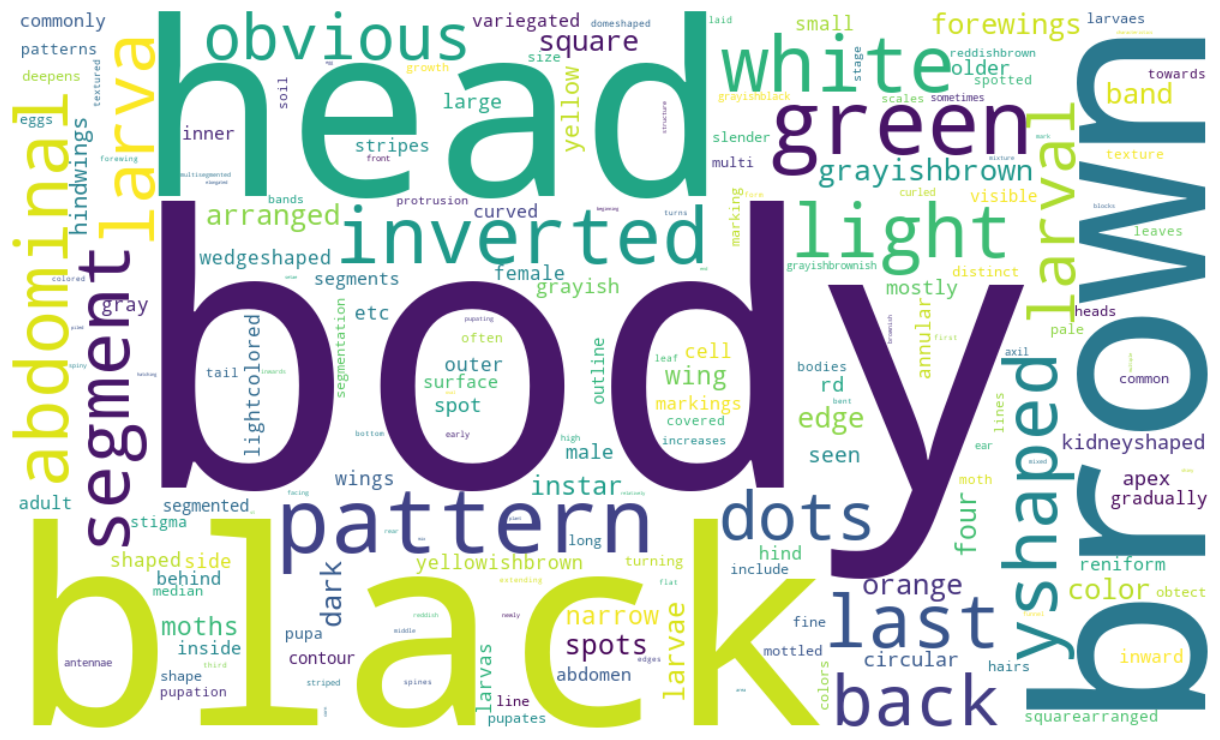

In [1]:
import os
import json
import re
import string
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# 下载必要的NLTK资源
nltk.download('punkt_tab')
nltk.download('stopwords')

def extract_characteristics(folder_path):
    """遍历文件夹，提取所有文件中的The Characteristics of pest EN字段"""
    characteristics_list = []
    # 遍历文件夹下的所有文件
    for filename in os.listdir(folder_path):
        # 仅处理txt文件（根据实际文件格式调整）
        if filename.endswith('.txt'):
            file_path = os.path.join(folder_path, filename)
            try:
                with open(file_path, 'r', encoding='utf-8') as f:
                    # 读取文件内容并解析为JSON
                    content = f.read()
                    # 处理可能的格式问题（如多余的逗号等）
                    content = re.sub(r',\s*}', '}', content)
                    data = json.loads(content)
                    
                    # 提取所有pest的characteristics
                    pest_num = 1
                    while True:
                        pest_key = f'pest {pest_num}'
                        if pest_key not in data:
                            break
                        # 获取EN特征字段
                        charac_en = data[pest_key].get('The Characteristics of pest EN', '')
                        if charac_en:
                            characteristics_list.append(charac_en)
                        pest_num += 1
                print(f"已处理文件: {filename}")
            except Exception as e:
                print(f"处理文件 {filename} 时出错: {str(e)}")
    return characteristics_list

def preprocess_text(text):
    """预处理文本：小写化、去除标点和特殊字符"""
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

def tokenize_and_filter(text):
    """分词并过滤停用词"""
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in tokens if token not in stop_words and len(token) > 1]
    return filtered_tokens

def generate_wordcloud(texts, output_file='pest_characteristics_wordcloud_feature.png'):
    """根据提取的特征生成词云"""
    combined_text = ' '.join(texts)
    processed_text = preprocess_text(combined_text)
    tokens = tokenize_and_filter(processed_text)
    word_freq = Counter(tokens)
    
    print(f"\n共提取到 {len(texts)} 条特征描述")
    print(f"处理后得到 {len(tokens)} 个有效词语，其中独特词语 {len(word_freq)} 个")
    print("出现频率最高的10个词：")
    for word, count in word_freq.most_common(10):
        print(f"{word}: {count}次")
    
    # 生成词云
    wordcloud = WordCloud(
        width=1000,
        height=600,
        background_color='white',
        max_words=300,
        contour_width=1,
        contour_color='green'  # 选用与害虫相关的绿色
    ).generate_from_frequencies(word_freq)
    
    # 显示并保存词云
    plt.figure(figsize=(12, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"\n词云已保存至 {output_file}")
    plt.show()

if __name__ == "__main__":
    # 目标文件夹路径（根据你的实际路径修改）
    folder_path = r'C:\Users\35088\Desktop\25.7.24\pest_text\api\data\caption_en\01_caoditanyee'
    
    # 提取特征描述
    print(f"开始遍历文件夹: {folder_path}")
    characteristics = extract_characteristics(folder_path)
    
    if characteristics:
        # 生成词云
        generate_wordcloud(characteristics)
    else:
        print("未提取到任何特征描述，请检查文件路径和文件格式")

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\35088\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\35088\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


开始遍历文件夹: C:\Users\35088\Desktop\25.7.24\pest_text\api\old_data\caption\01_caoditanyee
已处理文件: PD16-MW-00100000_caption.txt
已处理文件: PD16-MW-00100001_caption.txt
已处理文件: PD16-MW-00100002_caption.txt
已处理文件: PD16-MW-00100003_caption.txt
已处理文件: PD16-MW-00100004_caption.txt
已处理文件: PD16-MW-00100005_caption.txt
已处理文件: PD16-MW-00100006_caption.txt
已处理文件: PD16-MW-00100007_caption.txt
已处理文件: PD16-MW-00100008_caption.txt
已处理文件: PD16-MW-00100009_caption.txt
已处理文件: PD16-MW-00100010_caption.txt
已处理文件: PD16-MW-00100012_caption.txt
已处理文件: PD16-MW-00100013_caption.txt
已处理文件: PD16-MW-00100014_caption.txt
已处理文件: PD16-MW-00100015_caption.txt
已处理文件: PD16-MW-00100016_caption.txt
已处理文件: PD16-MW-00100017_caption.txt
已处理文件: PD16-MW-00100018_caption.txt
已处理文件: PD16-MW-00100019_caption.txt
已处理文件: PD16-MW-00100020_caption.txt
已处理文件: PD16-MW-00100022_caption.txt
已处理文件: PD16-MW-00100023_caption.txt
已处理文件: PD16-MW-00100024_caption.txt
已处理文件: PD16-MW-00100025_caption.txt
已处理文件: PD16-MW-00100026_caption.txt
已处理文件: PD16-MW

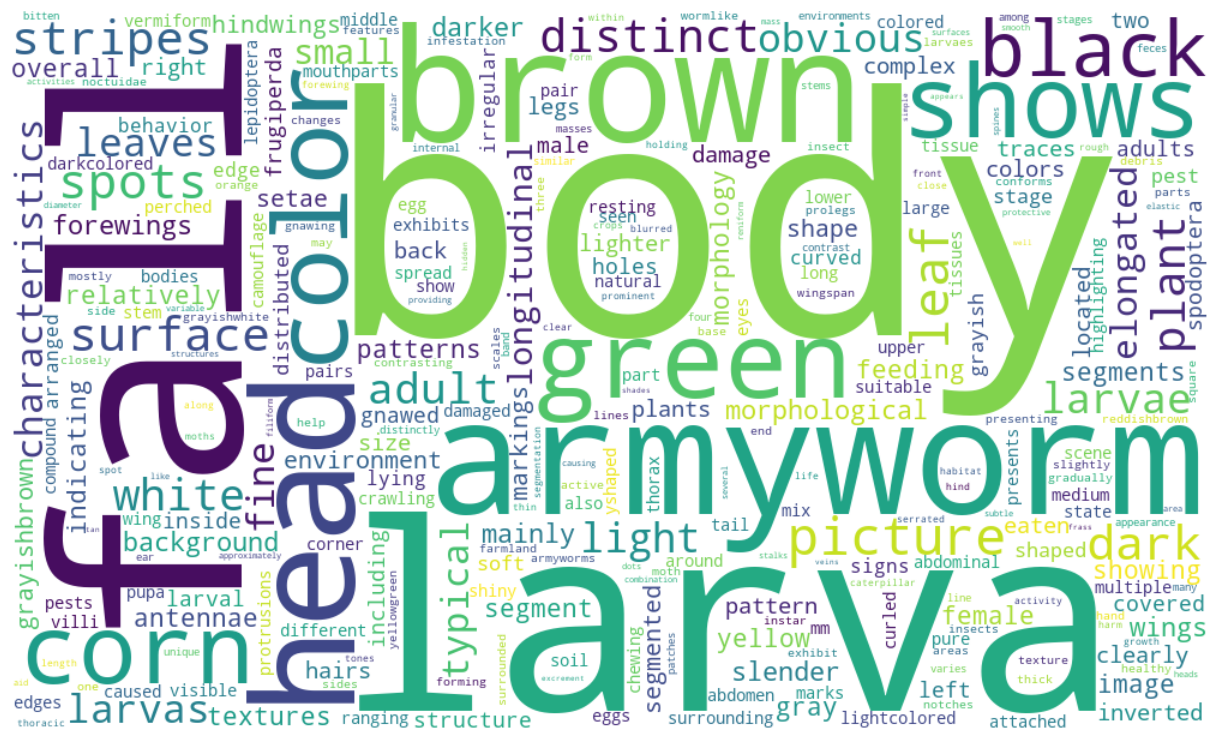

In [2]:
import os
import json
import re
import string
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# 下载必要的NLTK资源
nltk.download('punkt_tab')
nltk.download('stopwords')

def extract_characteristics(folder_path):
    """遍历文件夹，提取所有文件中的The image caption EN字段"""
    characteristics_list = []
    # 遍历文件夹下的所有文件
    for filename in os.listdir(folder_path):
        # 仅处理txt文件（根据实际文件格式调整）
        if filename.endswith('caption.txt'):
            file_path = os.path.join(folder_path, filename)
            try:
                with open(file_path, 'r', encoding='utf-8') as f:
                    # 读取文件内容并解析为JSON
                    content = f.read()
                    # 处理可能的格式问题（如多余的逗号等）
                    content = re.sub(r',\s*}', '}', content)
                    data = json.loads(content)
                    
                    # 提取所有pest的characteristics
                    charac_en = data.get('The image caption EN', '')
                    if charac_en:
                        characteristics_list.append(charac_en)
                print(f"已处理文件: {filename}")
            except Exception as e:
                print(f"处理文件 {filename} 时出错: {str(e)}")
    return characteristics_list

def preprocess_text(text):
    """预处理文本：小写化、去除标点和特殊字符"""
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

def tokenize_and_filter(text):
    """分词并过滤停用词"""
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in tokens if token not in stop_words and len(token) > 1]
    return filtered_tokens

def generate_wordcloud(texts, output_file='pest_characteristics_wordcloud_caption.png'):
    """根据提取的特征生成词云"""
    combined_text = ' '.join(texts)
    processed_text = preprocess_text(combined_text)
    tokens = tokenize_and_filter(processed_text)
    word_freq = Counter(tokens)
    
    print(f"\n共提取到 {len(texts)} 条特征描述")
    print(f"处理后得到 {len(tokens)} 个有效词语，其中独特词语 {len(word_freq)} 个")
    print("出现频率最高的10个词：")
    for word, count in word_freq.most_common(10):
        print(f"{word}: {count}次")
    
    # 生成词云
    wordcloud = WordCloud(
        width=1000,
        height=600,
        background_color='white',
        max_words=300,
        contour_width=1,
        contour_color='green'  # 选用与害虫相关的绿色
    ).generate_from_frequencies(word_freq)
    
    # 显示并保存词云
    plt.figure(figsize=(12, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"\n词云已保存至 {output_file}")
    plt.show()

if __name__ == "__main__":
    # 目标文件夹路径（根据你的实际路径修改）
    folder_path = r'C:\Users\35088\Desktop\25.7.24\pest_text\api\old_data\caption\01_caoditanyee'
    
    # 提取特征描述
    print(f"开始遍历文件夹: {folder_path}")
    characteristics = extract_characteristics(folder_path)
    
    if characteristics:
        # 生成词云
        generate_wordcloud(characteristics)
    else:
        print("未提取到任何特征描述，请检查文件路径和文件格式")